In [25]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [26]:
import numpy as np
import pandas as pd
from datetime import timedelta
from datetime import datetime

In [27]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
import datetime as dt

In [28]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [29]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [30]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [31]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [32]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [33]:
# Find the most recent date in the data set.

most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date


('2017-08-23',)

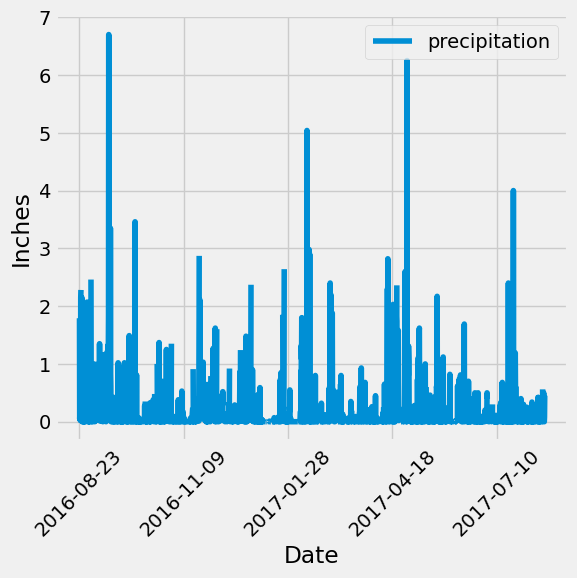

In [34]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
latest_date_str = session.query(func.max(Measurement.date)).scalar()

# Calculate the date one year from the last date in data set.
date_format = "%Y-%m-%d"
latest_date = datetime.strptime(latest_date_str, date_format)
one_year_ago = latest_date - timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(results, columns=['date', 'precipitation'])

# Sort the dataframe by date
df = df.sort_values(by='date')


# Use Pandas Plotting with Matplotlib to plot the data
df.plot(x='date', y='precipitation', kind='line', figsize=(6, 6))
plt.xlabel('Date')
plt.ylabel('Inches')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [35]:
# Use Pandas to calculate the summary statistics for the precipitation data
mean = df['precipitation'].mean()
mean

summary_stats = df.describe()
summary_stats


,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [36]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station.distinct())).all()
total_stations

[(9,)]

In [37]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

total_stations_row_count = (
    session.query(Station.station, func.count(Measurement.station))
    .join(Measurement, Station.station == Measurement.station)
    .group_by(Station.station)
    .order_by(func.count(Measurement.station).desc())
    .all()
   
)

total_stations_row_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [38]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = 'USC00519281'

temps_for_most_active_station = session.query(Measurement.tobs).filter(Measurement.station == most_active_station).all()

temps_for_most_active_station = [temp[0] for temp in temps_for_most_active_station]

# lowest, highest, and avg temps
min_temp = min(temps_for_most_active_station)
max_temp = max(temps_for_most_active_station)
avg_temp = sum(temps_for_most_active_station) / len(temps_for_most_active_station)


min_temp, max_temp, avg_temp

(54.0, 85.0, 71.66378066378067)

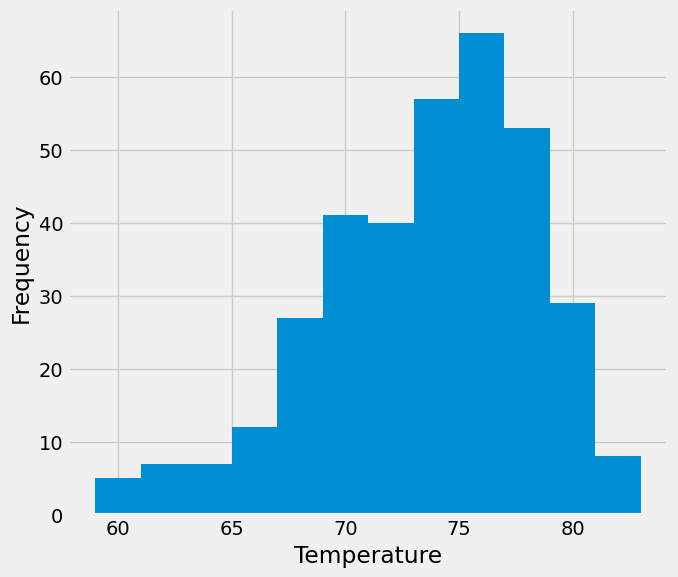

In [39]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

most_active_station = 'USC00519281'
most_recent_date_str = session.query(func.max(Measurement.date)).scalar()

# Calculate the date 
date_format = "%Y-%m-%d"
most_recent_date = datetime.strptime(most_recent_date_str, date_format)
one_year_ago = most_recent_date - timedelta(days=366)

# Query the last 12 months of temperature data
temps_last_year = (
    session.query(Measurement.tobs)
    .filter(Measurement.station == most_active_station)
    .filter(Measurement.date >= one_year_ago)
    .all()
)

# Getting temp values
temps_last_year = [temp[0] for temp in temps_last_year] 


plt.figure(figsize=(7,6))
plt.hist(temps_last_year, bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [40]:
# Close Session
session.close()